## Importing Relevant Libraries

In [1]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding, Flatten
from tensorflow.keras.preprocessing.text import one_hot
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
# nltk.download()
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)
# import these modules 
from nltk.stem import WordNetLemmatizer 

In [2]:
data = pd.read_csv('nlp-getting-started/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Data Cleaning

In [3]:
data_after_null_removal = data.copy()
data_after_null_removal = data_after_null_removal.dropna(subset=['location'])
# Removing duplicates
data_after_duplicate_removal = data_after_null_removal.drop_duplicates(subset=['text'])

# Location + texts
data_after_adding_location = data_after_duplicate_removal.copy()
data_after_adding_location['tweets'] = data_after_adding_location['text'].str.cat(data_after_adding_location['location'],sep=" ")
# removing location and text column
data_after_adding_location.drop(columns=['location', 'text'], inplace=True, axis=1)
data_after_adding_location

,id,keyword,target,tweets
31,48,ablaze,1,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C Birmingham
32,49,ablaze,0,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw Est. September 2012 - Bristol
33,50,ablaze,1,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi AFRICA
34,52,ablaze,0,"Crying out for more! Set me ablaze Philadelphia, PA"
35,53,ablaze,0,"On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N London, UK"
...,...,...,...,...
7575,10826,wrecked,0,On the bright side I wrecked http://t.co/uEa0txRHYs TN
7577,10829,wrecked,0,@widda16 ... He's gone. You can relax. I thought the wife who wrecked her cake was a goner mind ...
7579,10831,wrecked,0,Three days off from work and they've pretty much all been wrecked hahaha shoutout to my family f...
7580,10832,wrecked,0,#FX #forex #trading Cramer: Iger's 3 words that wrecked Disney's stock http://t.co/7enNulLKzM Lo...


In [4]:
nltk.download('stopwords')

#punctutation removal
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

data_afer_punctuation_removal = data_after_adding_location.copy()
data_afer_punctuation_removal['tweets'] = data_afer_punctuation_removal['tweets'].apply(lambda x: remove_punct(x))

# Tockenization

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data_afer_punctuation_removal.copy()
tockenized_data['tweets'] = tockenized_data['tweets'].apply(lambda x: tokenization(x.lower()))

# stopword removal 
data_after_stopword_removal = tockenized_data.copy()
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

data_after_stopword_removal['tweets'] = data_after_stopword_removal['tweets'].apply(lambda x: remove_stopwords(x))

# return to string
data_without_tockenization = data_after_stopword_removal.copy()
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
data_without_tockenization['tweets'] = data_without_tockenization['tweets'].apply(lambda x: listToString(x))
data_without_tockenization

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/patrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,target,tweets
31,48,ablaze,1,bbcmtd wholesale markets ablaze httptcolhyxeohyc birmingham
32,49,ablaze,0,always try bring heavy metal rt httptcoyaoexngw est september bristol
33,50,ablaze,1,africanbaze breaking newsnigeria flag set ablaze aba httptconndbgwyei africa
34,52,ablaze,0,crying set ablaze philadelphia pa
35,53,ablaze,0,plus side look sky last night ablaze httptcoqqsmshajn london uk
...,...,...,...,...
7575,10826,wrecked,0,bright side wrecked httptcoueatxrhys tn
7577,10829,wrecked,0,widda hes gone relax thought wife wrecked cake goner mind lol whoops newcastleupontyne uk
7579,10831,wrecked,0,three days work theyve pretty much wrecked hahaha shoutout family one vancouver canada
7580,10832,wrecked,0,fx forex trading cramer igers words wrecked disneys stock httptcoennullkzm london


In [6]:
### train - test split
training, testing = train_test_split(data_without_tockenization, test_size=0.1, random_state=42, shuffle=True)

In [7]:
train = training.copy()
test = testing.copy()
# get the dependent and independent variables
train_x = train['tweets']
train_y = train['target']
test_x = test['tweets']
test_y = test['target']

## Preprocessing

In [8]:
#Downloading wordnet
nltk.download('wordnet')

train_x = np.array(train_x)
train_y = np.array(train_y)


# only work with the 10000 most popular words found in our dataset
max_words = 20000

# create a new Tokenizer
tokenizer = Tokenizer(num_words=max_words)
# feed our tweets to the Tokenizer
tokenizer.fit_on_texts(train_x)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

# Saving the dictionary
with open('./Dictionary_Models/locdictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

# Function to convert the text to its corresponding index
def convert_text_to_index_array(text):
    return [dictionary[word] for word in kpt.text_to_word_sequence(text)]

# Lematizing the words
lemmatizer = WordNetLemmatizer()

allWordIndices = []
# for each tweet, lematize and change each token to its ID in the Tokenizer's word_index
for text in train_x:
    word = lemmatizer.lemmatize(text)
    wordIndices = convert_text_to_index_array(word)
    allWordIndices.append(wordIndices)

############################

# Embedding Representation

############################
# Padding each text so that it has the same length
text_length = 30
embedded_text = pad_sequences(allWordIndices, padding='pre', maxlen=text_length)

train_x = np.asarray(embedded_text)
train_y = keras.utils.to_categorical(train_y, 2)

[nltk_data] Downloading package wordnet to /home/patrick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Model

In [58]:
# Creating a model
embedding_features = 128
model = Sequential()
model.add(Embedding(input_dim=max_words,output_dim=embedding_features, input_length=text_length))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(6, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

print(model.summary())

history = model.fit(train_x, train_y,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)

model_json = model.to_json()
with open('./NN_Models/embed_keras_loc_model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('./NN_Models/embed_keras_loc_model.h5')

print('saved model!')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 30, 128)           2560000   
_________________________________________________________________
flatten_8 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               491648    
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 258       
Total params: 3,068,418
Trainable params: 3,068,418
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
32/32 [==============================] - 6s 195ms/step - loss: 0.6708 - accuracy: 0.5742 - val

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


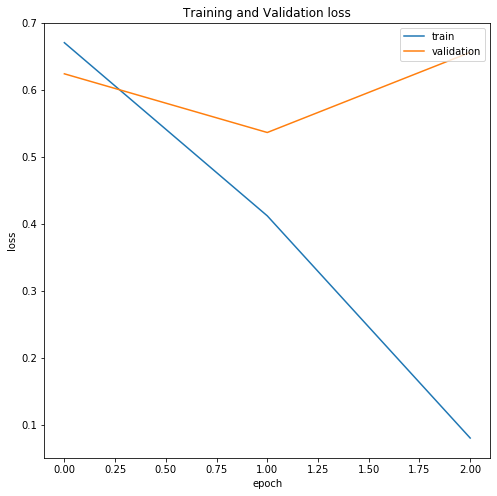

In [59]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [60]:
labels = ['fake', 'real']

# read in our saved dictionary
with open('./Dictionary_Models/locdictionary.json', 'r') as dictionary_file:
    dictionary = json.load(dictionary_file)

def convert_text_to_index_array(text):
    words = kpt.text_to_word_sequence(text)
    wordIndices = []
    for word in words:
        if word in dictionary:
            wordIndices.append(dictionary[word])

    return wordIndices

# read in your saved model structure
json_file = open('./NN_Models/embed_keras_loc_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
# and create a model from that
model = model_from_json(loaded_model_json)
# and weight your nodes with your saved values
model.load_weights('./NN_Models/embed_keras_loc_model.h5')

text_sequence = []

for index_of_interest, text1 in enumerate(test_x):
    # format your input for the neural net
    testArr = convert_text_to_index_array(text1)
    text_sequence.append(testArr)
    
padded_sequence = pad_sequences(text_sequence, padding='pre', maxlen=text_length)
predictions_before_formatting = model.predict(padded_sequence)

predictions = []
for num in predictions_before_formatting:
  predictions.append(np.argmax(num))
#end for

In [61]:
def rounding(results):
    '''Results needs to be rounded to 0 or 1 for fake or real, respectively'''
    if results < 0.5:
        return 0
    else:
        return 1
    
predictions_final = [rounding(x) for x in predictions]

In [62]:
predictions = np.array(predictions)
test_y = np.array(test_y)
confusion_matrix(test_y, predictions)

tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn +tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1_score = 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1_score], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df = pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,235,41
Positive,82,145


In [63]:
results

,Value
Accuracy,0.755467
Precision,0.779570
FPR,0.148551
Recall,0.638767
F1,0.702179


## Summary
- Model accuracy is around 76%
- Precision increases with an increase in embedding dimention
- Recall increases with a decrease in embedding dimensio (but 70% for embedding_dim=12)